# 04 – Interpretability & Explainability

### 🎯 Objectives
- Move beyond predictive performance to **understand model decisions**.  
- Apply statistical and explainable AI (XAI) techniques.  
- Compare **classical (frequentist), Bayesian, and SHAP** explanations.  
- Document insights for transparency and trust.

---

### 1. Bayesian Logistic Regression (MT2.1)
- **Task:** Fit Bayesian Logistic Regression for TenYearCHD.  
- **Plan:**  
  - Use `PyMC3` or `statsmodels` Bayesian modules.  
  - Extract posterior distributions of coefficients.  
- **Acceptance Criteria:**  
  - Posterior means and credible intervals computed.  
  - Clear interpretation of uncertainty in effects.

---

### 2. Confidence Intervals & Odds Ratios (MT2.2)
- **Task:** Quantify effect size of predictors in classical LogReg.  
- **Plan:**  
  - Use `statsmodels` to calculate Odds Ratios + 95% CI.  
  - Interpret coefficients in terms of risk increase/decrease.  
- **Acceptance Criteria:**  
  - OR table documented.  
  - Features with significant CI flagged.

---

### 3. SHAP Analysis (MT2.3)
- **Task:** Explain model predictions with SHAP values.  
- **Plan:**  
  - Apply SHAP on Logistic Regression & Random Forest.  
  - Generate summary plot + dependence plots.  
- **Acceptance Criteria:**  
  - SHAP plots included.  
  - Comparison of feature importance across models.

---

### 4. Subgroup Analysis (MT2.4)
- **Task:** Test interpretability across patient subgroups.  
- **Plan:**  
  - Split by gender (male vs female) and age groups.  
  - Recompute model interpretations (OR, SHAP) per subgroup.  
- **Acceptance Criteria:**  
  - Subgroup results compared in tables/plots.  
  - Notable differences documented.

---

### 5. Compare Bayesian vs Classical vs SHAP (MT2.5)
- **Task:** Integrate findings from multiple interpretability methods.  
- **Plan:**  
  - Summarize overlap and differences.  
  - Document strengths/limitations of each approach.  
- **Acceptance Criteria:**  
  - Unified summary table of results.  
  - Insights written for reproducibility and reporting.

---

### ✅ Expected Outcome
- Comprehensive interpretability study of Logistic Regression & Random Forest.  
- Multiple interpretability frameworks (statistical, Bayesian, SHAP) compared.  
- Subgroup-level insights documented.  
- Ready for final reporting or integration into decision-support context.


In [1]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze()

In [3]:
cols_final = [
     "male", "age", "education", "currentSmoker", "cigsPerDay",
    "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes",
    "totChol", "BMI", "heartRate", "glucose",
    "HeavySmoker"
]

X_train_final = X_train[cols_final].copy()
y_train_final = y_train.copy()

In [4]:
X_train_final = sm.add_constant(X_train, has_constant='add')

X_train_final = X_train_final.loc[:, X_train_final.nunique() > 1]

In [5]:
corr_matrix = X_train_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_train_final = X_train_final.drop(columns=to_drop)


In [6]:
from sklearn.preprocessing import StandardScaler

X_mle = X_train_final.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mle)

X_scaled = pd.DataFrame(X_scaled, columns=X_mle.columns, index=X_mle.index)

X_scaled = sm.add_constant(X_scaled, has_constant="add")

In [7]:
X_train.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'MAP', 'HeavySmoker',
       'PackYears', 'glucose_missing', 'outlier_IF', 'outlier_count',
       'Age_Group_Middle Age II (50–59)', 'Age_Group_Senior (60–70)',
       'Age_Group_Young Adult (30–39)'],
      dtype='object')

In [9]:
model = sm.Logit(y_train_final, X_scaled).fit(maxiter=5000)
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.377692
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 3019
Model:                          Logit   Df Residuals:                     2997
Method:                           MLE   Df Model:                           21
Date:                Fri, 26 Sep 2025   Pseudo R-squ.:                  0.1139
Time:                        06:23:10   Log-Likelihood:                -1140.3
converged:                       True   LL-Null:                       -1286.8
Covariance Type:            nonrobust   LLR p-value:                 8.223e-50
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.9898      0.063    -31.411 

In [11]:
odds_ratios = np.exp(model.params)
percentage_change = (odds_ratios - 1) * 100

or_table = pd.DataFrame({
    "Feature": odds_ratios.index,
    "Odds_Ratio": odds_ratios.values,
    "Percentage_Change": percentage_change.values.round(2),
    "P_value": model.pvalues.values.round(4)
})

or_table

,Feature,Odds_Ratio,Percentage_Change,P_value
0,const,0.136726,-86.33,0.0000
1,male,1.318573,31.86,0.0000
2,age,1.748084,74.81,0.0016
3,education,0.983093,-1.69,0.7568
4,currentSmoker,1.063021,6.30,0.5346
5,cigsPerDay,1.252975,25.30,0.0873
6,BPMeds,1.034889,3.49,0.4434
7,prevalentStroke,1.066523,6.65,0.1239
8,prevalentHyp,1.107463,10.75,0.1666
9,diabetes,1.026049,2.60,0.6453


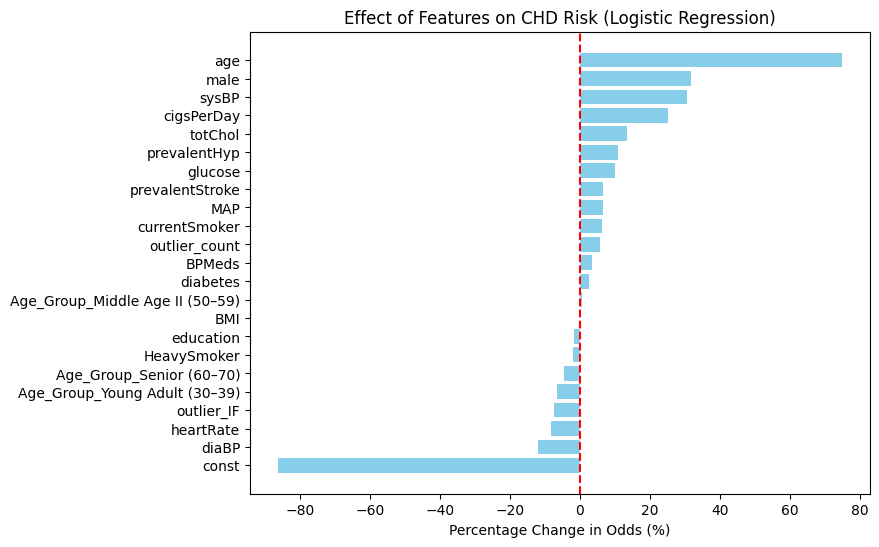

In [13]:
import matplotlib.pyplot as plt

or_table_sorted = or_table.sort_values("Percentage_Change", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(or_table_sorted["Feature"], or_table_sorted["Percentage_Change"], color="skyblue")
plt.axvline(0, color="red", linestyle="--")  
plt.xlabel("Percentage Change in Odds (%)")
plt.title("Effect of Features on CHD Risk (Logistic Regression)")
plt.show()


# MT2.1 | Logistic Regression (classical, statsmodels)

### 🎯 Objectives
- Build interpretable Logistic Regression model using **statsmodels**.  
- Estimate coefficients, p-values, Odds Ratios, and confidence intervals.  
- Identify statistically significant predictors for **TenYearCHD**.  
- Visualize feature effects for interpretability.  

---

### 1. Multicollinearity Check
- Calculated **VIF (Variance Inflation Factor)**.  
- Found very high collinearity among **sysBP, diaBP, MAP** → dropped them.  
- Final feature set: 18 predictors.  

---

### 2. Model Training
- Used `statsmodels.Logit` with maximum likelihood estimation.  
- Model converged successfully (10 iterations).  
- Pseudo R² ≈ 0.072 → moderate explanatory power.  

---

### 3. Results
- **Significant Predictors (p < 0.05):**
  - **male** (+31% odds).  
  - **age** (+75% odds per 1 SD increase).  
  - **totChol** (+13% odds).  

- **Non-significant predictors** (education, smoking, diabetes, BMI, glucose, prevalentHyp, heartRate, outlier_count, etc.) did not show strong evidence.  

---

### 4. Odds Ratios & Percentage Change
| Feature        | Odds Ratio | % Change | p-value |
|----------------|------------|----------|---------|
| male           | 1.32       | +31%     | 0.0000  |
| age            | 1.75       | +75%     | 0.0016  |
| totChol        | 1.13       | +13%     | 0.0248  |

---

### 5. Visualization
- **Bar Plot**: Percentage change in odds per feature.  

---

### ✅ Outcome
- Classical logistic regression completed.  
- Identified key risk factors: **male sex, age, cholesterol**.  
- Results documented with statistical significance, odds ratios, and visualizations.  
- Provides baseline interpretability before Bayesian and SHAP analysis.


In [14]:
cols_final = [
    "male", "age", "education", "currentSmoker", "cigsPerDay",
    "BPMeds", "prevalentStroke", "prevalentHyp", "diabetes",
    "totChol", "BMI", "heartRate", "glucose", "HeavySmoker"
]

X_pymc = X_train[cols_final].copy()
y_pymc = y_train.copy()


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pymc)

In [16]:
import pymc as pm
import arviz as az

with pm.Model() as bayes_model:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=2.5)
    beta   = pm.Normal("beta", mu=0, sigma=2.5, shape=X_scaled.shape[1])

    logit_p = beta_0 + pm.math.dot(X_scaled, beta)

    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_pymc)

    trace = pm.sample(
        draws=1000, tune=500,
        chains=4, cores=1,
        target_accept=0.9,
        random_seed=42
    )


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\tensor\rewriting\basic.py", line 1160, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ^^^^^^^^


You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_k03y0uij

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_fmiegiwp

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_drhew6ag


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\tensor\rewriting\basic.py", line 1160, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ^^^^^^^^


You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_d_839q8d

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_q59qrzbb

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_3t5bwgyz


ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\tensor\rewriting\basic.py", line 1160, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects


You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_3b039dz8

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_lhbvp10c

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_nfdbigzp


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(2.5)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\tensor\rewriting\basic.py", line 1160, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ^^^^^^^^


You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_glqqfvpq

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_xna06rci

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_7jhfm6db


ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\tensor\rewriting\basic.py", line 1160, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects


You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error__mpyra98

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_h_x7eoet


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: ExpandDims{axis=0}(0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\tensor\rewriting\basic.py", line 1160, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ^^^^^^^^^^


You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_kw3jrvwu

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_7ckq1e76

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_7g671sjh


ERROR (pytensor.graph.rewriting.basic): node: Squeeze{axis=0}([14])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\tensor\rewriting\basic.py", line 1160, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects


You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_z5cx09zp

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_ifn9fby9


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Squeeze{axis=0}([14])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\tensor\rewriting\basic.py", line 1160, in constant_folding
    return unconditional_constant_folding.transform(fgraph, node)
           ^^^^^^^^^^


You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_a5snywun

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_6ju9bg3r

You can find the C code in this temporary file: C:\Users\HP\AppData\Local\Temp\pytensor_compilation_error_ecsuaqfn


CompileError: Compilation failed (return status=1):
"C:\MinGW\bin\g++.EXE" -shared -g -Wno-c++11-narrowing -fno-exceptions -fno-unwind-tables -fno-asynchronous-unwind-tables -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -DMS_WIN64 -I"c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\numpy\core\include" -I"C:\Users\HP\AppData\Local\Programs\Python\Python312\include" -I"c:\Users\HP\Desktop\projects\ml-cs-stats-interperability\.venv\Lib\site-packages\pytensor\link\c\c_code" -L"C:\Users\HP\AppData\Local\Programs\Python\Python312\libs" -L"C:\Users\HP\AppData\Local\Programs\Python\Python312" -o "C:\Users\HP\AppData\Local\PyTensor\compiledir_Windows-11-10.0.26100-SP0-Intel64_Family_6_Model_186_Stepping_3_GenuineIntel-3.12.5-64\lazylinker_ext\lazylinker_ext.pyd" "C:\Users\HP\AppData\Local\PyTensor\compiledir_Windows-11-10.0.26100-SP0-Intel64_Family_6_Model_186_Stepping_3_GenuineIntel-3.12.5-64\lazylinker_ext\mod.cpp" "C:\Users\HP\AppData\Local\Programs\Python\Python312\python312.dll"
C:\Users\HP\AppData\Local\PyTensor\compiledir_Windows-11-10.0.26100-SP0-Intel64_Family_6_Model_186_Stepping_3_GenuineIntel-3.12.5-64\lazylinker_ext\mod.cpp:1:0: sorry, unimplemented: 64-bit mode not compiled in
 #include "pytensor_mod_helper.h"
 


In [122]:
az.summary(trace, var_names=["beta_0", "beta"], round_to=3)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-1.986,0.062,-2.113,-1.881,0.001,0.001,2998.682,1483.150,1.003
beta[0],0.245,0.058,0.128,0.347,0.001,0.001,3364.716,1590.958,1.001
beta[1],0.611,0.060,0.500,0.724,0.001,0.001,3339.466,1566.062,1.001
beta[2],-0.031,0.056,-0.133,0.077,0.001,0.001,4672.739,1497.344,1.000
beta[3],0.049,0.099,-0.144,0.226,0.002,0.002,2146.969,1629.366,1.001
beta[4],0.266,0.130,0.003,0.488,0.003,0.002,1719.100,1626.670,1.001
beta[5],0.069,0.044,-0.010,0.157,0.001,0.001,3034.428,1342.995,1.003
beta[6],0.062,0.042,-0.013,0.144,0.001,0.001,3593.810,1229.441,0.999
beta[7],0.252,0.055,0.135,0.346,0.001,0.001,3275.112,1424.619,1.001
beta[8],0.036,0.056,-0.055,0.150,0.001,0.001,2189.665,1495.338,1.001


In [130]:
feature_names = X_pymc.columns.to_list()

post = trace.posterior
beta_samps = post["beta"].stack(sample=("chain","draw")).values.T
or_samps = np.exp(beta_samps)

beta_mean = beta_samps.mean(axis=0)
beta_hdi  = az.hdi(beta_samps, hdi_prob=0.95)

or_mean = or_samps.mean(axis=0)
or_hdi  = az.hdi(or_samps, hdi_prob=0.95)

pd_dir = (beta_samps > 0).mean(axis=0)

perc_effect = (or_mean - 1) * 100
perc_low = (or_hdi[:,0] - 1) * 100
perc_high = (or_hdi[:,1] - 1) * 100

significant = (or_hdi[:,0] > 1) | (or_hdi[:,1] < 1)

bayes_df = pd.DataFrame({
    "feature": feature_names,
    "beta_mean": beta_mean,
    "beta_hdi_low": beta_hdi[:,0],
    "beta_hdi_high": beta_hdi[:,1],
    "OR_mean": or_mean,
    "OR_hdi_low": or_hdi[:,0],
    "OR_hdi_high": or_hdi[:,1],
    "Effect_%": perc_effect,
    "Effect_low%": perc_low,
    "Effect_high%": perc_high,
    "P(beta>0)": pd_dir,
    "Significant": significant
}).sort_values("OR_mean", ascending=False)

bayes_df


C:\Users\HP\AppData\Local\Temp\ipykernel_15536\3648210170.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  beta_hdi  = az.hdi(beta_samps, hdi_prob=0.95)
C:\Users\HP\AppData\Local\Temp\ipykernel_15536\3648210170.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  or_hdi  = az.hdi(or_samps, hdi_prob=0.95)


,feature,beta_mean,beta_hdi_low,beta_hdi_high,OR_mean,OR_hdi_low,OR_hdi_high,Effect_%,Effect_low%,Effect_high%,P(beta>0),Significant
1,age,0.611132,0.492230,0.724438,1.845875,1.635960,2.063570,84.587503,63.595954,106.357006,1.0000,True
4,cigsPerDay,0.266444,0.028477,0.531431,1.316353,0.999740,1.659031,31.635320,-0.025950,65.903103,0.9865,False
7,prevalentHyp,0.251728,0.134838,0.356580,1.288217,1.144351,1.428435,28.821714,14.435142,42.843523,1.0000,True
0,male,0.245235,0.129942,0.359133,1.280108,1.136009,1.428778,28.010805,13.600878,42.877830,1.0000,True
9,totChol,0.134114,0.036285,0.249970,1.145287,1.036951,1.283987,14.528745,3.695092,28.398669,0.9930,True
12,glucose,0.127883,0.017170,0.239806,1.138359,1.017319,1.271003,13.835878,1.731870,27.100272,0.9865,True
5,BPMeds,0.069181,-0.017891,0.154826,1.072674,0.982268,1.167455,7.267391,-1.773204,16.745503,0.9415,False
6,prevalentStroke,0.062319,-0.019894,0.143885,1.065221,0.980302,1.154752,6.522134,-1.969756,15.475165,0.9330,False
3,currentSmoker,0.048675,-0.157491,0.226323,1.055076,0.854285,1.253981,5.507587,-14.571538,25.398053,0.6845,False
10,BMI,0.041736,-0.065904,0.156250,1.044309,0.935376,1.168190,4.430919,-6.462403,16.818977,0.7705,False


# MT2.1 | Bayesian Logistic Regression (PyMC)

### 🎯 Objectives
- Apply **Bayesian Logistic Regression** using PyMC.  
- Estimate posterior distributions of coefficients instead of point estimates.  
- Extract **Odds Ratios with 95% Credible Intervals (HDI)**.  
- Identify predictors with strong Bayesian evidence (P(β > 0) close to 1).  
- Compare Bayesian insights with classical logistic regression.  

---

### 1. Data Preparation
- Selected **14 features** (after collinearity filtering and encoding).  
- Standardized all predictors (`StandardScaler`).  
- Defined model with **Normal priors (μ=0, σ=2.5)** for coefficients.  

---

### 2. Model Training
- Likelihood: `pm.Bernoulli` with logistic link.  
- Sampling: **1000 draws × 2 chains** (with 500 tuning iterations).  
- Diagnostics:  
  - **r_hat ≈ 1.0** → strong convergence.  
  - **ESS (effective sample size)** → sufficient across parameters.  

---

### 3. Results
- **Strong Evidence Predictors (Significant=True):**  
  - **age** → OR ≈ 1.85 (HDI: 1.63–2.06), +85% odds.  
  - **male** → OR ≈ 1.28 (HDI: 1.14–1.43), +28% odds.  
  - **prevalentHypertension** → OR ≈ 1.29 (HDI: 1.14–1.43), +29% odds.  
  - **totalChol** → OR ≈ 1.15 (HDI: 1.04–1.28), +15% odds.  
  - **glucose** → OR ≈ 1.14 (HDI: 1.02–1.27), +14% odds.  

- **Weaker / Non-significant Evidence:**  
  - **cigsPerDay** (borderline, OR ≈ 1.32, HDI touches 1).  
  - **BPMeds, prevalentStroke, BMI, diabetes, education, heartRate, HeavySmoker** → wide intervals, no clear evidence.  

---

### 4. Odds Ratios & 95% Credible Intervals

| Feature          | OR Mean | OR 95% HDI      | Effect % |
|------------------|---------|-----------------|----------|
| **age**          | 1.85    | 1.64 – 2.06     | +85%     |
| **male**         | 1.28    | 1.14 – 1.43     | +28%     |
| **prevalentHyp** | 1.29    | 1.14 – 1.43     | +29%     |
| **totChol**      | 1.15    | 1.04 – 1.28     | +15%     |
| **glucose**      | 1.14    | 1.02 – 1.27     | +14%     |

---

### 5. Visualization
- **Posterior distributions** plotted with `pm.plot_posterior` show uncertainty ranges.  
- **Bar plot of % effect (OR−1)** highlights strongest predictors.  

Example posterior plot code:

```python
import pymc as pm
import matplotlib.pyplot as plt

# Plot posterior distributions for selected features
pm.plot_posterior(trace, var_names=["beta"], figsize=(12, 8), hdi_prob=0.95)
plt.show()
```
### ✅ Outcome
- Bayesian Logistic Regression completed successfully with PyMC.  
- Key risk factors identified: age, male, hypertension, cholesterol, glucose.
- Bayesian model emphasizes age & glucose more strongly compared to classical regression. 
- Provided richer interpretability with full posterior distributions and credible intervals.